In [ ]:
# ============================================
# CELL 1: Setup environment
# - Install TensorFlow versi stabil (2.19.0)
# - Import library utama
# - Cek GPU
# - Set seed agar hasil lebih konsisten (reproducible)
# ============================================

!pip -q install -U "tensorflow==2.19.0"

import os, time, random, tempfile
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

SEED = 42
tf.keras.utils.set_random_seed(SEED)

print("TF version:", tf.__version__)
print("GPU devices:", tf.config.list_physical_devices("GPU"))
!nvidia-smi -L


TF version: 2.19.0
GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU 0: Tesla T4 (UUID: GPU-83d1565a-856c-4425-03cf-49ec8110cc5a)


In [ ]:
# ============================================
# CELL 2: Mount Drive & set path dataset
# - Menghubungkan Google Drive
# - Set folder dataset split ala paper (dataset_ready_paper)
# ============================================

from google.colab import drive
drive.mount("/content/drive")

BASE_DIR  = "/content/drive/MyDrive/semester 7/Skripsi/dataset"
READY_DIR = os.path.join(BASE_DIR, "dataset_ready_custom")

TRAIN_DIR = os.path.join(READY_DIR, "train")
VAL_DIR   = os.path.join(READY_DIR, "val")
TEST_DIR  = os.path.join(READY_DIR, "test")

print("READY_DIR:", READY_DIR)
print("train exists:", os.path.exists(TRAIN_DIR))
print("val exists  :", os.path.exists(VAL_DIR))
print("test exists :", os.path.exists(TEST_DIR))


Mounted at /content/drive
READY_DIR: /content/drive/MyDrive/semester 7/Skripsi/dataset/dataset_ready_custom
train exists: True
val exists  : True
test exists : True


In [ ]:
# ============================================
# CELL 3: Verifikasi split dataset
# - Mengecek jumlah file per kelas di train/val/test
# - Target paper: Train=1600 (400/kelas), Val=80 (20/kelas), Test=80 (20/kelas)
# ============================================

def count_images_per_class(split_dir):
    counts = {}
    for cls in sorted(os.listdir(split_dir)):
        cls_path = os.path.join(split_dir, cls)
        if os.path.isdir(cls_path):
            counts[cls] = len([f for f in os.listdir(cls_path)
                               if f.lower().endswith((".jpg",".jpeg",".png"))])
    return counts, sum(counts.values())

for split, path in [("TRAIN", TRAIN_DIR), ("VAL", VAL_DIR), ("TEST", TEST_DIR)]:
    cnt, total = count_images_per_class(path)
    print(split, cnt, "TOTAL:", total)

print("\nTarget : Train=1732 (433/kelas), Val=80 (20/kelas), Test=80 (20/kelas)")


TRAIN {'cordana': 433, 'healthy': 433, 'pestalotiopsis': 433, 'sigatoka': 433} TOTAL: 1732
VAL {'cordana': 20, 'healthy': 20, 'pestalotiopsis': 20, 'sigatoka': 20} TOTAL: 80
TEST {'cordana': 20, 'healthy': 20, 'pestalotiopsis': 20, 'sigatoka': 20} TOTAL: 80

Target : Train=1732 (433/kelas), Val=80 (20/kelas), Test=80 (20/kelas)


In [ ]:
# ============================================
# CELL 4: Load dataset dengan tf.data
# - Membaca gambar dari folder train/val/test
# - Normalisasi TIDAK dilakukan di sini,
# karena akan dilakukan di dalam model via preprocess_input
# ============================================

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 4
AUTOTUNE = tf.data.AUTOTUNE

train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    shuffle=True,
    seed=SEED
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    VAL_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    shuffle=False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    shuffle=False
)

class_names = train_ds.class_names
print("Class order:", class_names)

# Prefetch agar loading lebih cepat
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds   = val_ds.cache().prefetch(AUTOTUNE)
test_ds  = test_ds.cache().prefetch(AUTOTUNE)


Found 1732 files belonging to 4 classes.
Found 80 files belonging to 4 classes.
Found 80 files belonging to 4 classes.
Class order: ['cordana', 'healthy', 'pestalotiopsis', 'sigatoka']


In [ ]:
# ============================================
# CELL 5: Konfigurasi training (FE + FT)
# - Stage 1 = Fixed Feature (freeze backbone)
# - Stage 2 = Fine-tuning (unfreeze last N layer)
# - Regularisasi + callbacks
# ============================================

# ---------- STAGE 1 (Fixed Feature) ----------
EPOCHS_STAGE1 = 15
LR_STAGE1 = 1e-3

# ---------- STAGE 2 (Fine-tuning) ----------
EPOCHS_STAGE2 = 10
# LR_STAGE2 akan di-set per varian (FT10/FT20/FT30)

DROPOUT_RATE = 0.4

metrics = [
    tf.keras.metrics.CategoricalAccuracy(name="acc")
]

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
]

loss_fn = tf.keras.losses.CategoricalCrossentropy()

print("Config loaded.")
print("Stage1:", EPOCHS_STAGE1, "| LR:", LR_STAGE1)
print("Stage2:", EPOCHS_STAGE2, "| LR: set per variant")
print("Dropout:", DROPOUT_RATE)


Config loaded.
Stage1: 15 | LR: 0.001
Stage2: 10 | LR: set per variant
Dropout: 0.4


In [ ]:
# ============================================
# CELL 6: Build model (EfficientNetB0)
# - Head classifier dibuat sama:
# GAP -> Dropout -> Dense(softmax)
# - backbone.trainable=False untuk FE
# ============================================

from tensorflow.keras import layers

def build_efficientnetb0():
    inputs = tf.keras.Input(shape=IMG_SIZE + (3,), name="input")

    backbone = tf.keras.applications.EfficientNetB0(
        include_top=False, weights="imagenet", input_shape=IMG_SIZE + (3,)
    )
    backbone.trainable = False  # FE: freeze dari awal

    x = tf.keras.applications.efficientnet.preprocess_input(inputs)
    x = backbone(x, training=False)

    x = layers.GlobalAveragePooling2D(name="gap")(x)
    x = layers.Dropout(DROPOUT_RATE, seed=SEED, name="dropout")(x)
    outputs = layers.Dense(
        NUM_CLASSES, activation="softmax",
        name="classifier"
    )(x)

    model = tf.keras.Model(inputs, outputs, name="efficientnetb0_model")
    return model, backbone


In [ ]:
# ============================================
# CELL 7: Utils evaluasi (test, model size, inference, confusion)
# ============================================

from sklearn.metrics import classification_report, confusion_matrix

def get_model_size_mb(model):
    with tempfile.NamedTemporaryFile(suffix=".keras", delete=True) as tmp:
        model.save(tmp.name, include_optimizer=False)
        return os.path.getsize(tmp.name) / (1024 * 1024)

def eval_model(model):
    y_true, y_pred = [], []
    for x, y in test_ds:
        p = model.predict(x, verbose=0)
        y_true += list(np.argmax(y.numpy(), axis=1))
        y_pred += list(np.argmax(p, axis=1))

    cm = confusion_matrix(y_true, y_pred)
    rep = classification_report(
        y_true, y_pred,
        target_names=class_names,
        output_dict=True,
        digits=4
    )
    return cm, rep

def inference_ms_per_batch(model, ds, warmup_batches=1, measure_batches=2):
    for x, _ in ds.take(warmup_batches):
        _ = model.predict(x, verbose=0)

    times = []
    for x, _ in ds.take(measure_batches):
        t0 = time.time()
        _ = model.predict(x, verbose=0)
        t1 = time.time()
        times.append((t1 - t0) * 1000)

    return float(np.mean(times)), float(np.std(times))

def make_global_matrix(rep, params, size_mb, inf_mean, inf_std, train_time):
    return pd.DataFrame({
        "Metric": [
            "Accuracy", "Macro Precision", "Macro Recall", "Macro F1", "Weighted F1",
            "Params", "Model Size (MB)",
            "Inference Mean (ms/batch)", "Inference Std (ms/batch)",
            "Train Time (s)"
        ],
        "Value": [
            rep["accuracy"],
            rep["macro avg"]["precision"],
            rep["macro avg"]["recall"],
            rep["macro avg"]["f1-score"],
            rep["weighted avg"]["f1-score"],
            params, size_mb, inf_mean, inf_std,
            train_time
        ]
    })

def make_confusion_table(cm):
    return pd.DataFrame(
        cm,
        index=[f"Actual_{c}" for c in class_names],
        columns=[f"Pred_{c}" for c in class_names]
    )

def plot_confusion_matrix_blue(cm, classes, title="Confusion Matrix"):
    plt.figure(figsize=(6,5))
    im = plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar(im, fraction=0.046, pad=0.04)

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha="right")
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.0 if cm.max() > 0 else 0.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(
                j, i, format(cm[i, j], "d"),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black",
                fontsize=11, fontweight="bold"
            )

    plt.ylabel("Actual Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.show()


In [ ]:
# ============================================
# CELL 8: Utils MACs & FLOPs (TF 2.19)
# ============================================

from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2_as_graph

def get_macs_and_flops(model, input_shape=(1, 224, 224, 3)):
    func = tf.function(model).get_concrete_function(
        tf.TensorSpec(input_shape, model.inputs[0].dtype)
    )
    frozen_func, graph_def = convert_variables_to_constants_v2_as_graph(func)

    with tf.Graph().as_default() as graph:
        tf.graph_util.import_graph_def(graph_def, name="")
        run_meta = tf.compat.v1.RunMetadata()
        opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()

        flops = tf.compat.v1.profiler.profile(
            graph=graph,
            run_meta=run_meta,
            cmd="op",
            options=opts
        )

    total_flops = float(flops.total_float_ops)
    total_macs = float(total_flops / 2)
    return total_macs, total_flops


In [ ]:
# ============================================
# CELL 9: Utils Robust (ACC only + AVG + wide)
# - Struktur folder: <transform>_<level>/<class>/*.jpg
# - Transform: brightness_down/up, blur, salt_pepper
# - Level: low/medium/high
# ============================================

ROBUST_FIX_DIR = "/content/drive/MyDrive/semester 7/Skripsi/dataset/uji robust fix"

robust_transforms = ["brightness_down", "brightness_up", "blur", "salt_pepper"]
robust_levels = ["low", "medium", "high"]

def load_robust_ds(transform, level, class_names):
    folder_name = f"{transform}_{level}"
    folder_path = os.path.join(ROBUST_FIX_DIR, folder_name)

    if not os.path.exists(folder_path):
        print(f"[WARN] Folder tidak ditemukan, skip: {folder_path}")
        return None

    ds = tf.keras.utils.image_dataset_from_directory(
        folder_path,
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        label_mode="categorical",
        shuffle=False,
        class_names=class_names
    ).prefetch(tf.data.AUTOTUNE)

    return ds

def eval_robust_model_acc(model, robust_ds):
    y_true, y_pred = [], []
    for x, y in robust_ds:
        preds = model.predict(x, verbose=0)
        y_true.extend(np.argmax(y.numpy(), axis=1))
        y_pred.extend(np.argmax(preds, axis=1))

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return float(np.mean(y_true == y_pred))

def run_robust_eval_one_variant(model_tag, model):
    print(f"\n=== Evaluasi {model_tag} pada Data Test Robust ===")

    rows = []
    acc_list = []

    for transform in robust_transforms:
        for level in robust_levels:
            ds = load_robust_ds(transform, level, class_names)
            if ds is None:
                continue

            acc = eval_robust_model_acc(model, ds)
            acc_list.append(acc)

            print(f"{transform:16s} | {level:6s} | Acc = {acc:.4f}")

            rows.append({
                "Variant": model_tag,
                "Transform": transform,
                "Level": level,
                "Accuracy": acc
            })

    avg_acc = float(np.mean(acc_list)) if len(acc_list) > 0 else np.nan
    print(f"\n➡️ Average Accuracy (Semua Robust): {avg_acc:.4f}")

    rows.append({
        "Variant": model_tag,
        "Transform": "AVG_ALL",
        "Level": "-",
        "Accuracy": avg_acc
    })

    robust_df = pd.DataFrame(rows)

    robust_wide = robust_df[robust_df["Transform"] != "AVG_ALL"].pivot_table(
        index=["Transform", "Level"],
        columns="Variant",
        values="Accuracy"
    ).reset_index()

    return robust_df, robust_wide, avg_acc


In [ ]:
# ============================================
# CELL X: Plot Training History (Accuracy & Loss)
# ============================================

def plot_history(history, title_prefix=""):
    acc_key = "acc" if "acc" in history else "categorical_accuracy"
    val_acc_key = "val_acc" if "val_acc" in history else "val_categorical_accuracy"

    epochs = range(1, len(history["loss"]) + 1)

    plt.figure(figsize=(14,5))

    # ----- Accuracy -----
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history[acc_key], label="Train Acc")
    plt.plot(epochs, history[val_acc_key], label="Val Acc")
    plt.title(f"{title_prefix} Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)

    # ----- Loss -----
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Val Loss")
    plt.title(f"{title_prefix} Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


In [ ]:
# ============================================
# CELL 10: Helper Fine-tuning
# - Membuka (unfreeze) last N layer pada backbone
# - BatchNorm tetap freeze agar training stabil
# ============================================

def set_trainable_last_n(backbone, last_n=10):
    backbone.trainable = True

    # freeze semua dulu
    for layer in backbone.layers:
        layer.trainable = False

    # unfreeze last N (kecuali BatchNorm)
    trainable = 0
    for layer in backbone.layers[-last_n:]:
        if isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = False
        else:
            layer.trainable = True
            trainable += 1

    return trainable

def fmt(x):
    if isinstance(x, (int, float, np.floating)):
        return f"{x:.4f}"
    return x


#Fixed Feature

In [ ]:
# ============================================
# CELL FE-1: Build model + compile (FE)
# ============================================

ef_model, ef_backbone = build_efficientnetb0()
print("Backbone trainable:", ef_backbone.trainable)
ef_model.summary()

ef_model.compile(
    optimizer=tf.keras.optimizers.Adam(LR_STAGE1),
    loss=loss_fn,
    metrics=metrics
)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Backbone trainable: False


Model: "efficientnetb0_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gap (GlobalAveragePooling2D)    │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier (Dense)              │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,054,695 (15.47 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
# ============================================
# CELL FE-2: Train Fixed Feature (FE)
# - Output training akan menampilkan acc, loss, val_acc, val_loss
# ============================================

t0 = time.time()
h_fe = ef_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_STAGE1,
    callbacks=callbacks,
    verbose=1
)
t1 = time.time()

fe_train_time = float(t1 - t0)
fe_hist = h_fe.history

# Simpan bobot terbaik FE (karena restore_best_weights=True)
FE_BEST_WEIGHTS = ef_model.get_weights()

print("FE train time (s):", fe_train_time)
print("FE epochs ran:", len(fe_hist["loss"]))


Epoch 1/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 264s 4s/step - acc: 0.5964 - loss: 1.0118 - val_acc: 0.9250 - val_loss: 0.3238
Epoch 2/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - acc: 0.8945 - loss: 0.3308 - val_acc: 0.9875 - val_loss: 0.2004
Epoch 3/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - acc: 0.9309 - loss: 0.2287 - val_acc: 0.9875 - val_loss: 0.1580
Epoch 4/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - acc: 0.9587 - loss: 0.1747 - val_acc: 0.9875 - val_loss: 0.1301
Epoch 5/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - acc: 0.9593 - loss: 0.1560 - val_acc: 0.9875 - val_loss: 0.1155
Epoch 6/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - acc: 0.9670 - loss: 0.1310 - val_acc: 0.9875 - val_loss: 0.1051
Epoch 7/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - acc: 0.9747 - loss: 0.1146 - val_acc: 0.9875 - val_loss: 0.0989
Epoch 8/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - acc: 0.9734 - loss: 0.1064 - val_acc: 0.9875 - val_loss: 0.0930
Epoch 9/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - acc: 0.9784

=== GLOBAL METRICS: EF (FE) ===


,Metric,Value
0,Accuracy,9.750000e-01
1,Macro Precision,9.761905e-01
2,Macro Recall,9.750000e-01
3,Macro F1,9.746470e-01
4,Weighted F1,9.746470e-01
5,Params,4.054695e+06
6,Model Size (MB),1.631442e+01
7,Inference Mean (ms/batch),1.040800e+02
8,Inference Std (ms/batch),3.736496e+00
9,Train Time (s),2.896824e+02


,Pred_cordana,Pred_healthy,Pred_pestalotiopsis,Pred_sigatoka
Actual_cordana,20,0,0,0
Actual_healthy,0,20,0,0
Actual_pestalotiopsis,0,0,20,0
Actual_sigatoka,1,0,1,18


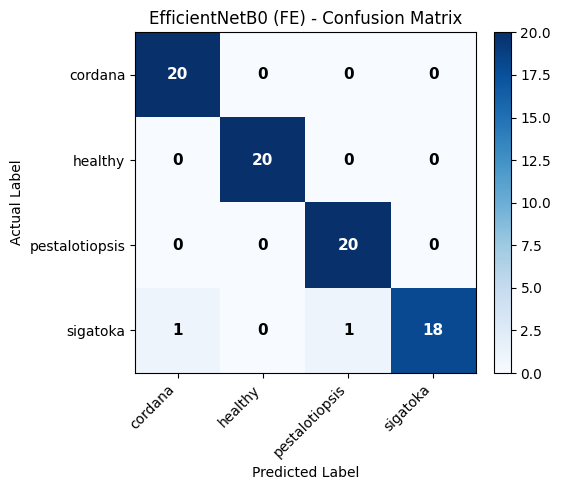

In [ ]:
# ============================================
# CELL FE-3: Eval FE (Test set)
# - Global metrics + confusion matrix table + heatmap
# ============================================

fe_cm, fe_rep = eval_model(ef_model)

fe_params = ef_model.count_params()
fe_size_mb = get_model_size_mb(ef_model)
fe_inf_mean, fe_inf_std = inference_ms_per_batch(ef_model, test_ds)

fe_global = make_global_matrix(
    fe_rep, fe_params, fe_size_mb,
    fe_inf_mean, fe_inf_std,
    fe_train_time
)
fe_cm_df = make_confusion_table(fe_cm)

print("=== GLOBAL METRICS: EF (FE) ===")
display(fe_global)
display(fe_cm_df)

plot_confusion_matrix_blue(fe_cm, class_names, "EfficientNetB0 (FE) - Confusion Matrix")


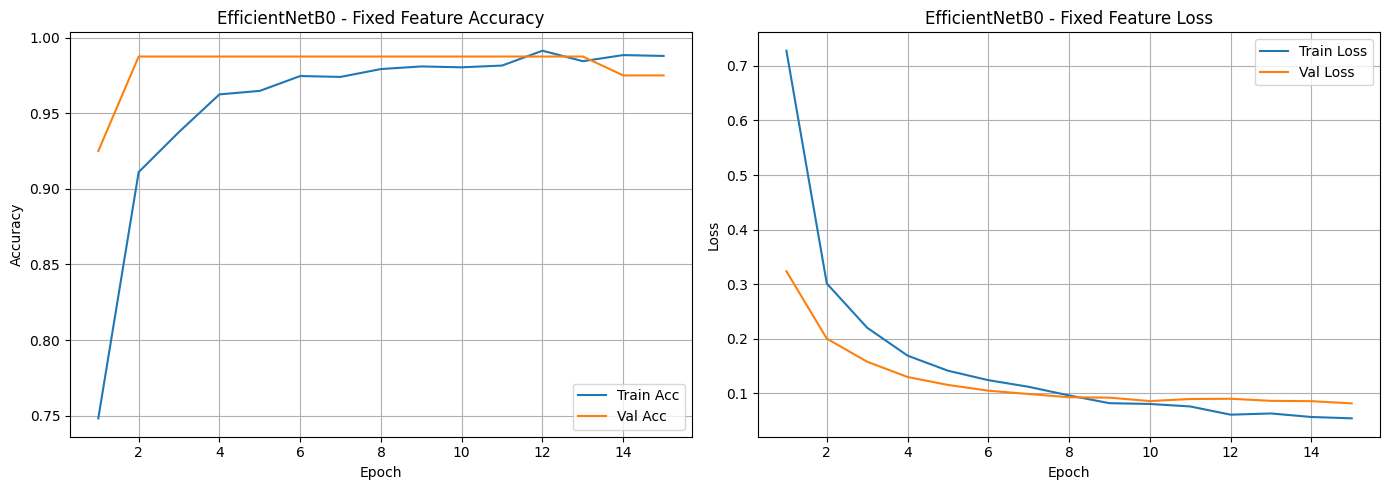

In [ ]:
# ============================================
# CELL FE-PLOT: Accuracy & Loss (Fixed Feature)
# ============================================

plot_history(fe_hist, title_prefix="EfficientNetB0 - Fixed Feature")


In [ ]:
# ============================================
# CELL FE-4: Robust FE
# ============================================

fe_robust_df, fe_robust_wide, fe_avg_rob = run_robust_eval_one_variant("EF_FE", ef_model)

print("\n=== ROBUST TABLE (EF_FE) ===")
display(fe_robust_df)
display(fe_robust_wide)
print("AVG Robustness (EF_FE):", fe_avg_rob)


=== Evaluasi EF_FE pada Data Test Robust ===
Found 80 files belonging to 4 classes.
brightness_down  | low    | Acc = 0.9750
Found 80 files belonging to 4 classes.
brightness_down  | medium | Acc = 0.9625
Found 80 files belonging to 4 classes.
brightness_down  | high   | Acc = 0.9625
Found 80 files belonging to 4 classes.
brightness_up    | low    | Acc = 0.9750
Found 80 files belonging to 4 classes.
brightness_up    | medium | Acc = 0.9875
Found 80 files belonging to 4 classes.
brightness_up    | high   | Acc = 0.9875
Found 80 files belonging to 4 classes.
blur             | low    | Acc = 0.9750
Found 80 files belonging to 4 classes.
blur             | medium | Acc = 0.9125
Found 80 files belonging to 4 classes.
blur             | high   | Acc = 0.8000
Found 80 files belonging to 4 classes.
salt_pepper      | low    | Acc = 0.9000
Found 80 files belonging to 4 classes.
salt_pepper      | medium | Acc = 0.8500
Found 80 files belonging to 4 classes.
salt_pepper      | high   | Acc = 0

,Variant,Transform,Level,Accuracy
0,EF_FE,brightness_down,low,0.975000
1,EF_FE,brightness_down,medium,0.962500
2,EF_FE,brightness_down,high,0.962500
3,EF_FE,brightness_up,low,0.975000
4,EF_FE,brightness_up,medium,0.987500
5,EF_FE,brightness_up,high,0.987500
6,EF_FE,blur,low,0.975000
7,EF_FE,blur,medium,0.912500
8,EF_FE,blur,high,0.800000
9,EF_FE,salt_pepper,low,0.900000


Variant,Transform,Level,EF_FE
0,blur,high,0.8000
1,blur,low,0.9750
2,blur,medium,0.9125
3,brightness_down,high,0.9625
4,brightness_down,low,0.9750
5,brightness_down,medium,0.9625
6,brightness_up,high,0.9875
7,brightness_up,low,0.9750
8,brightness_up,medium,0.9875
9,salt_pepper,high,0.6750


AVG Robustness (EF_FE): 0.9135416666666667


In [ ]:
# ============================================
# CELL FE-5: MACs & FLOPs FE
# ============================================

fe_macs, fe_flops = get_macs_and_flops(ef_model)

print("=== EFISIENSI KOMPUTASI (EF_FE) ===")
print(f"EfficientNetB0: MACs = {fe_macs/1e6:.2f} MMACs | FLOPs = {fe_flops/1e6:.2f} MFLOPs")


Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.


=== EFISIENSI KOMPUTASI (EF_FE) ===
EfficientNetB0: MACs = 400.40 MMACs | FLOPs = 800.80 MFLOPs


In [ ]:
# ============================================
# CELL FE-6: Save FE model
# ============================================

MODEL_DIR = "/content/drive/MyDrive/semester 7/Skripsi/models/efficientnetb0all"
os.makedirs(MODEL_DIR, exist_ok=True)

EF_FE_PATH = os.path.join(MODEL_DIR, "efficientnetb0_fixedfeature.keras")
ef_model.save(EF_FE_PATH, include_optimizer=False)

print("Saved:", EF_FE_PATH)


Saved: /content/drive/MyDrive/semester 7/Skripsi/models/efficientnetb0all/efficientnetb0_fixedfeature.keras


In [ ]:
# ============================================
# CELL FE-7: Final metric table (FE)
# ============================================

fe_epochs_ran = len(fe_hist["loss"])
fe_train_time_per_epoch = fe_train_time / fe_epochs_ran
fe_test_ms_per_image = fe_inf_mean / BATCH_SIZE
fe_acc = float(fe_rep["accuracy"])

final_fe_df = pd.DataFrame({
    "Metric": [
        "Training time/epoch (s)",
        "Testing time/image (ms)",
        "Model size (MB)",
        "FLOPs (MFLOPs)",
        "MACs (MMACs)",
        "Accuracy",
        "Avg Robustness (acc)"
    ],
    "EF_FE": [
        fe_train_time_per_epoch,
        fe_test_ms_per_image,
        fe_size_mb,
        fe_flops / 1e6,
        fe_macs / 1e6,
        fe_acc,
        fe_avg_rob
    ]
})

final_fe_df["EF_FE"] = final_fe_df["EF_FE"].map(fmt)

print("=== HASIL AKHIR EF_FE ===")
display(final_fe_df)


=== HASIL AKHIR EF_FE ===


,Metric,EF_FE
0,Training time/epoch (s),19.3122
1,Testing time/image (ms),3.2525
2,Model size (MB),16.3144
3,FLOPs (MFLOPs),800.7954
4,MACs (MMACs),400.3977
5,Accuracy,0.9750
6,Avg Robustness (acc),0.9135


#FT10

In [ ]:
# ============================================
# CELL FT10-1: Set Fine-tuning FT10 + compile
# - Start dari bobot FE terbaik
# - Unfreeze last N = 10
# - LR kecil untuk fine-tuning
# ============================================

ef_model.set_weights(FE_BEST_WEIGHTS)

FT_LAST_N = 10
LR_STAGE2 = 2e-4

unfrozen = set_trainable_last_n(ef_backbone, last_n=FT_LAST_N)
print("Trainable backbone layers (non-BN) in last N:", unfrozen)

ef_model.compile(
    optimizer=tf.keras.optimizers.Adam(LR_STAGE2),
    loss=loss_fn,
    metrics=metrics
)

Trainable backbone layers (non-BN) in last N: 8


In [ ]:
# ============================================
# CELL FT10-2: Train FT10
# ============================================

t0 = time.time()
h_ft10 = ef_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_STAGE2,
    callbacks=callbacks,
    verbose=1
)
t1 = time.time()

ft10_train_time = float(t1 - t0)
ft10_hist = h_ft10.history

print("FT10 train time (s):", ft10_train_time)
print("FT10 epochs ran:", len(ft10_hist["loss"]))


Epoch 1/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 47s 447ms/step - acc: 0.9859 - loss: 0.0480 - val_acc: 0.9875 - val_loss: 0.0723
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - acc: 0.9898 - loss: 0.0258 - val_acc: 0.9750 - val_loss: 0.1066
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - acc: 0.9898 - loss: 0.0276 - val_acc: 0.9750 - val_loss: 0.0807
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - acc: 0.9916 - loss: 0.0232 - val_acc: 0.9750 - val_loss: 0.0895
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - acc: 0.9943 - loss: 0.0124 - val_acc: 0.9750 - val_loss: 0.0825
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - acc: 0.9960 - loss: 0.0101 - val_acc: 0.9875 - val_loss: 0.0891
FT10 train time (s): 55.87020301818848
FT10 epochs ran: 6


=== GLOBAL METRICS: EF_FT10 ===


,Metric,Value
0,Accuracy,9.750000e-01
1,Macro Precision,9.761905e-01
2,Macro Recall,9.750000e-01
3,Macro F1,9.746470e-01
4,Weighted F1,9.746470e-01
5,Params,4.054695e+06
6,Model Size (MB),2.310872e+01
7,Inference Mean (ms/batch),1.031836e+02
8,Inference Std (ms/batch),4.605055e-01
9,Train Time (s),5.587020e+01


,Pred_cordana,Pred_healthy,Pred_pestalotiopsis,Pred_sigatoka
Actual_cordana,20,0,0,0
Actual_healthy,0,20,0,0
Actual_pestalotiopsis,0,0,20,0
Actual_sigatoka,1,0,1,18


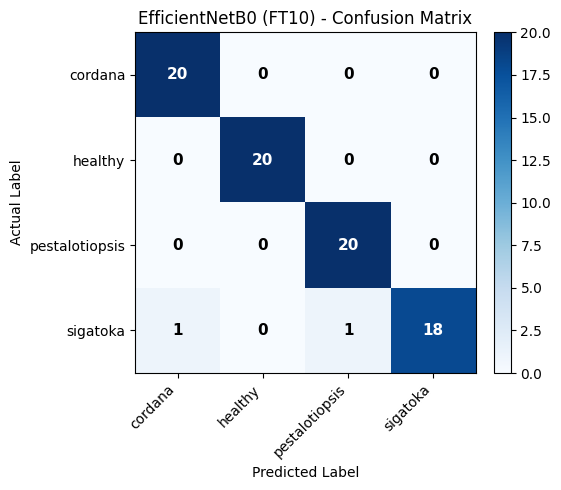

In [ ]:
# ============================================
# CELL FT10-3: Eval FT10 (Test set)
# ============================================

ft10_cm, ft10_rep = eval_model(ef_model)

ft10_params = ef_model.count_params()
ft10_size_mb = get_model_size_mb(ef_model)
ft10_inf_mean, ft10_inf_std = inference_ms_per_batch(ef_model, test_ds)

ft10_global = make_global_matrix(
    ft10_rep, ft10_params, ft10_size_mb,
    ft10_inf_mean, ft10_inf_std,
    ft10_train_time
)
ft10_cm_df = make_confusion_table(ft10_cm)

print("=== GLOBAL METRICS: EF_FT10 ===")
display(ft10_global)
display(ft10_cm_df)

plot_confusion_matrix_blue(ft10_cm, class_names, "EfficientNetB0 (FT10) - Confusion Matrix")


In [ ]:
# ============================================
# CELL FT10-4: Robust FT10
# ============================================

ft10_robust_df, ft10_robust_wide, ft10_avg_rob = run_robust_eval_one_variant("EF_FT10", ef_model)

print("\n=== ROBUST TABLE (EF_FT10) ===")
display(ft10_robust_df)
display(ft10_robust_wide)
print("AVG Robustness (EF_FT10):", ft10_avg_rob)



=== Evaluasi EF_FT10 pada Data Test Robust ===
Found 80 files belonging to 4 classes.
brightness_down  | low    | Acc = 0.9750
Found 80 files belonging to 4 classes.
brightness_down  | medium | Acc = 0.9625
Found 80 files belonging to 4 classes.
brightness_down  | high   | Acc = 0.9750
Found 80 files belonging to 4 classes.
brightness_up    | low    | Acc = 0.9875
Found 80 files belonging to 4 classes.
brightness_up    | medium | Acc = 0.9875
Found 80 files belonging to 4 classes.
brightness_up    | high   | Acc = 0.9750
Found 80 files belonging to 4 classes.
blur             | low    | Acc = 0.9625
Found 80 files belonging to 4 classes.
blur             | medium | Acc = 0.9000
Found 80 files belonging to 4 classes.
blur             | high   | Acc = 0.7875
Found 80 files belonging to 4 classes.
salt_pepper      | low    | Acc = 0.9125
Found 80 files belonging to 4 classes.
salt_pepper      | medium | Acc = 0.8625
Found 80 files belonging to 4 classes.
salt_pepper      | high   | Acc =

,Variant,Transform,Level,Accuracy
0,EF_FT10,brightness_down,low,0.975000
1,EF_FT10,brightness_down,medium,0.962500
2,EF_FT10,brightness_down,high,0.975000
3,EF_FT10,brightness_up,low,0.987500
4,EF_FT10,brightness_up,medium,0.987500
5,EF_FT10,brightness_up,high,0.975000
6,EF_FT10,blur,low,0.962500
7,EF_FT10,blur,medium,0.900000
8,EF_FT10,blur,high,0.787500
9,EF_FT10,salt_pepper,low,0.912500


Variant,Transform,Level,EF_FT10
0,blur,high,0.7875
1,blur,low,0.9625
2,blur,medium,0.9000
3,brightness_down,high,0.9750
4,brightness_down,low,0.9750
5,brightness_down,medium,0.9625
6,brightness_up,high,0.9750
7,brightness_up,low,0.9875
8,brightness_up,medium,0.9875
9,salt_pepper,high,0.8500


AVG Robustness (EF_FT10): 0.928125


In [ ]:
# ============================================
# CELL FT10-5: MACs & FLOPs FT10
# ============================================

ft10_macs, ft10_flops = get_macs_and_flops(ef_model)

print("=== EFISIENSI KOMPUTASI (EF_FT10) ===")
print(f"EfficientNetB0: MACs = {ft10_macs/1e6:.2f} MMACs | FLOPs = {ft10_flops/1e6:.2f} MFLOPs")


=== EFISIENSI KOMPUTASI (EF_FT10) ===
EfficientNetB0: MACs = 400.40 MMACs | FLOPs = 800.80 MFLOPs


In [ ]:
# ============================================
# CELL FT10-6: Save FT10 model
# ============================================

EF_FT10_PATH = os.path.join(MODEL_DIR, "efficientnetb0_ft10.keras")
ef_model.save(EF_FT10_PATH, include_optimizer=False)

print("Saved:", EF_FT10_PATH)


Saved: /content/drive/MyDrive/semester 7/Skripsi/models/efficientnetb0all/efficientnetb0_ft10.keras


In [ ]:
# ============================================
# CELL FT10-7: Final metric table (FT10)
# ============================================

ft10_epochs_ran = len(ft10_hist["loss"])
ft10_train_time_per_epoch = ft10_train_time / ft10_epochs_ran
ft10_test_ms_per_image = ft10_inf_mean / BATCH_SIZE
ft10_acc = float(ft10_rep["accuracy"])

final_ft10_df = pd.DataFrame({
    "Metric": [
        "Training time/epoch (s)",
        "Testing time/image (ms)",
        "Model size (MB)",
        "FLOPs (MFLOPs)",
        "MACs (MMACs)",
        "Accuracy",
        "Avg Robustness (acc)"
    ],
    "EF_FT10": [
        ft10_train_time_per_epoch,
        ft10_test_ms_per_image,
        ft10_size_mb,
        ft10_flops / 1e6,
        ft10_macs / 1e6,
        ft10_acc,
        ft10_avg_rob
    ]
})

final_ft10_df["EF_FT10"] = final_ft10_df["EF_FT10"].map(fmt)

print("=== HASIL AKHIR EF_FT10 ===")
display(final_ft10_df)


=== HASIL AKHIR EF_FT10 ===


,Metric,EF_FT10
0,Training time/epoch (s),9.3117
1,Testing time/image (ms),3.2245
2,Model size (MB),23.1087
3,FLOPs (MFLOPs),800.7954
4,MACs (MMACs),400.3977
5,Accuracy,0.9750
6,Avg Robustness (acc),0.9281


#FT20

In [ ]:
# ============================================
# CELL FT20-1: Set Fine-tuning FT20 + compile
# ============================================

ef_model.set_weights(FE_BEST_WEIGHTS)

FT_LAST_N = 20
LR_STAGE2 = 4e-5

unfrozen = set_trainable_last_n(ef_backbone, last_n=FT_LAST_N)
print("Trainable backbone layers (non-BN) in last N:", unfrozen)

ef_model.compile(
    optimizer=tf.keras.optimizers.Adam(LR_STAGE2),
    loss=loss_fn,
    metrics=metrics
)


Trainable backbone layers (non-BN) in last N: 15


In [ ]:
# ============================================
# CELL FT20-2: Train FT20
# ============================================

t0 = time.time()
h_ft20 = ef_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_STAGE2,
    callbacks=callbacks,
    verbose=1
)
t1 = time.time()

ft20_train_time = float(t1 - t0)
ft20_hist = h_ft20.history

print("FT20 train time (s):", ft20_train_time)
print("FT20 epochs ran:", len(ft20_hist["loss"]))


Epoch 1/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 55s 451ms/step - acc: 0.9900 - loss: 0.0480 - val_acc: 0.9875 - val_loss: 0.0731
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - acc: 0.9919 - loss: 0.0278 - val_acc: 0.9875 - val_loss: 0.0768
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - acc: 0.9923 - loss: 0.0277 - val_acc: 0.9875 - val_loss: 0.0786
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - acc: 0.9959 - loss: 0.0196 - val_acc: 0.9750 - val_loss: 0.0736
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - acc: 0.9924 - loss: 0.0177 - val_acc: 0.9875 - val_loss: 0.0731
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - acc: 0.9972 - loss: 0.0138 - val_acc: 0.9750 - val_loss: 0.0793
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - acc: 0.9936 - loss: 0.0164 - val_acc: 0.9875 - val_loss: 0.0694
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - acc: 0.9933 - loss: 0.0169 - val_acc: 0.9875 - val_loss: 0.0814
Epoch 9/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - acc: 0.99

=== GLOBAL METRICS: EF_FT20 ===


,Metric,Value
0,Accuracy,9.750000e-01
1,Macro Precision,9.761905e-01
2,Macro Recall,9.750000e-01
3,Macro F1,9.746470e-01
4,Weighted F1,9.746470e-01
5,Params,4.054695e+06
6,Model Size (MB),2.656533e+01
7,Inference Mean (ms/batch),1.017847e+02
8,Inference Std (ms/batch),1.343012e+00
9,Train Time (s),7.324814e+01


,Pred_cordana,Pred_healthy,Pred_pestalotiopsis,Pred_sigatoka
Actual_cordana,20,0,0,0
Actual_healthy,0,20,0,0
Actual_pestalotiopsis,0,0,20,0
Actual_sigatoka,1,0,1,18


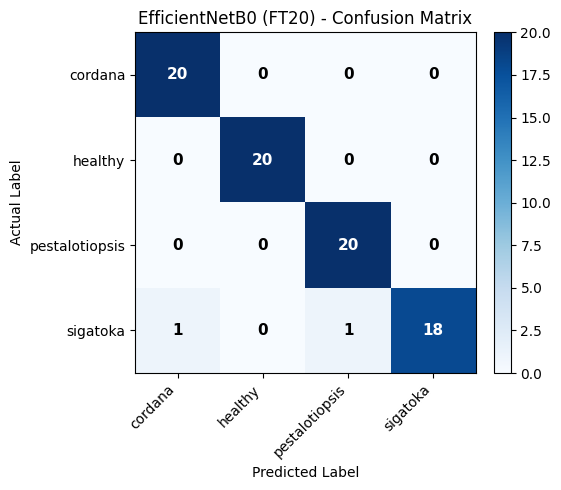

In [ ]:
# ============================================
# CELL FT20-3: Eval FT20 (Test set)
# ============================================

ft20_cm, ft20_rep = eval_model(ef_model)

ft20_params = ef_model.count_params()
ft20_size_mb = get_model_size_mb(ef_model)
ft20_inf_mean, ft20_inf_std = inference_ms_per_batch(ef_model, test_ds)

ft20_global = make_global_matrix(
    ft20_rep, ft20_params, ft20_size_mb,
    ft20_inf_mean, ft20_inf_std,
    ft20_train_time
)
ft20_cm_df = make_confusion_table(ft20_cm)

print("=== GLOBAL METRICS: EF_FT20 ===")
display(ft20_global)
display(ft20_cm_df)

plot_confusion_matrix_blue(ft20_cm, class_names, "EfficientNetB0 (FT20) - Confusion Matrix")


In [ ]:
# ============================================
# CELL FT20-4: Robust FT20
# ============================================

ft20_robust_df, ft20_robust_wide, ft20_avg_rob = run_robust_eval_one_variant("EF_FT20", ef_model)

print("\n=== ROBUST TABLE (EF_FT20) ===")
display(ft20_robust_df)
display(ft20_robust_wide)
print("AVG Robustness (EF_FT20):", ft20_avg_rob)



=== Evaluasi EF_FT20 pada Data Test Robust ===
Found 80 files belonging to 4 classes.
brightness_down  | low    | Acc = 0.9875
Found 80 files belonging to 4 classes.
brightness_down  | medium | Acc = 0.9750
Found 80 files belonging to 4 classes.
brightness_down  | high   | Acc = 0.9750
Found 80 files belonging to 4 classes.
brightness_up    | low    | Acc = 0.9875
Found 80 files belonging to 4 classes.
brightness_up    | medium | Acc = 0.9875
Found 80 files belonging to 4 classes.
brightness_up    | high   | Acc = 0.9875
Found 80 files belonging to 4 classes.
blur             | low    | Acc = 0.9750
Found 80 files belonging to 4 classes.
blur             | medium | Acc = 0.9375
Found 80 files belonging to 4 classes.
blur             | high   | Acc = 0.8750
Found 80 files belonging to 4 classes.
salt_pepper      | low    | Acc = 0.9250
Found 80 files belonging to 4 classes.
salt_pepper      | medium | Acc = 0.8625
Found 80 files belonging to 4 classes.
salt_pepper      | high   | Acc =

,Variant,Transform,Level,Accuracy
0,EF_FT20,brightness_down,low,0.987500
1,EF_FT20,brightness_down,medium,0.975000
2,EF_FT20,brightness_down,high,0.975000
3,EF_FT20,brightness_up,low,0.987500
4,EF_FT20,brightness_up,medium,0.987500
5,EF_FT20,brightness_up,high,0.987500
6,EF_FT20,blur,low,0.975000
7,EF_FT20,blur,medium,0.937500
8,EF_FT20,blur,high,0.875000
9,EF_FT20,salt_pepper,low,0.925000


Variant,Transform,Level,EF_FT20
0,blur,high,0.8750
1,blur,low,0.9750
2,blur,medium,0.9375
3,brightness_down,high,0.9750
4,brightness_down,low,0.9875
5,brightness_down,medium,0.9750
6,brightness_up,high,0.9875
7,brightness_up,low,0.9875
8,brightness_up,medium,0.9875
9,salt_pepper,high,0.7375


AVG Robustness (EF_FT20): 0.9343750000000002


In [ ]:
# ============================================
# CELL FT20-5: MACs & FLOPs FT20
# ============================================

ft20_macs, ft20_flops = get_macs_and_flops(ef_model)

print("=== EFISIENSI KOMPUTASI (EF_FT20) ===")
print(f"EfficientNetB0: MACs = {ft20_macs/1e6:.2f} MMACs | FLOPs = {ft20_flops/1e6:.2f} MFLOPs")


=== EFISIENSI KOMPUTASI (EF_FT20) ===
EfficientNetB0: MACs = 400.40 MMACs | FLOPs = 800.80 MFLOPs


In [ ]:
# ============================================
# CELL FT20-6: Save FT20 model
# ============================================

EF_FT20_PATH = os.path.join(MODEL_DIR, "efficientnetb0_ft20.keras")
ef_model.save(EF_FT20_PATH, include_optimizer=False)

print("Saved:", EF_FT20_PATH)


Saved: /content/drive/MyDrive/semester 7/Skripsi/models/efficientnetb0all/efficientnetb0_ft20.keras


In [ ]:
# ============================================
# CELL FT20-7: Final metric table (FT20)
# ============================================

ft20_epochs_ran = len(ft20_hist["loss"])
ft20_train_time_per_epoch = ft20_train_time / ft20_epochs_ran
ft20_test_ms_per_image = ft20_inf_mean / BATCH_SIZE
ft20_acc = float(ft20_rep["accuracy"])

final_ft20_df = pd.DataFrame({
    "Metric": [
        "Training time/epoch (s)",
        "Testing time/image (ms)",
        "Model size (MB)",
        "FLOPs (MFLOPs)",
        "MACs (MMACs)",
        "Accuracy",
        "Avg Robustness (acc)"
    ],
    "EF_FT20": [
        ft20_train_time_per_epoch,
        ft20_test_ms_per_image,
        ft20_size_mb,
        ft20_flops / 1e6,
        ft20_macs / 1e6,
        ft20_acc,
        ft20_avg_rob
    ]
})

final_ft20_df["EF_FT20"] = final_ft20_df["EF_FT20"].map(fmt)

print("=== HASIL AKHIR EF_FT20 ===")
display(final_ft20_df)


=== HASIL AKHIR EF_FT20 ===


,Metric,EF_FT20
0,Training time/epoch (s),7.3248
1,Testing time/image (ms),3.1808
2,Model size (MB),26.5653
3,FLOPs (MFLOPs),800.7954
4,MACs (MMACs),400.3977
5,Accuracy,0.9750
6,Avg Robustness (acc),0.9344


#FT30

In [ ]:
# ============================================
# CELL FT30-1: Set Fine-tuning FT30 + compile
# ============================================

ef_model.set_weights(FE_BEST_WEIGHTS)

FT_LAST_N = 30
LR_STAGE2 = 8e-6

unfrozen = set_trainable_last_n(ef_backbone, last_n=FT_LAST_N)
print("Trainable backbone layers (non-BN) in last N:", unfrozen)

ef_model.compile(
    optimizer=tf.keras.optimizers.Adam(LR_STAGE2),
    loss=loss_fn,
    metrics=metrics
)


Trainable backbone layers (non-BN) in last N: 23


In [ ]:
# ============================================
# CELL FT30-2: Train FT30
# ============================================

t0 = time.time()
h_ft30 = ef_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_STAGE2,
    callbacks=callbacks,
    verbose=1
)
t1 = time.time()

ft30_train_time = float(t1 - t0)
ft30_hist = h_ft30.history

print("FT30 train time (s):", ft30_train_time)
print("FT30 epochs ran:", len(ft30_hist["loss"]))


Epoch 1/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 50s 468ms/step - acc: 0.9925 - loss: 0.0433 - val_acc: 0.9750 - val_loss: 0.0792
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - acc: 0.9889 - loss: 0.0444 - val_acc: 0.9750 - val_loss: 0.0793
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - acc: 0.9866 - loss: 0.0453 - val_acc: 0.9750 - val_loss: 0.0790
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - acc: 0.9918 - loss: 0.0387 - val_acc: 0.9750 - val_loss: 0.0791
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - acc: 0.9889 - loss: 0.0359 - val_acc: 0.9750 - val_loss: 0.0779
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - acc: 0.9872 - loss: 0.0394 - val_acc: 0.9750 - val_loss: 0.0769
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - acc: 0.9980 - loss: 0.0208 - val_acc: 0.9750 - val_loss: 0.0763
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - acc: 0.9901 - loss: 0.0253 - val_acc: 0.9750 - val_loss: 0.0762
Epoch 9/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - acc: 0.99

=== GLOBAL METRICS: EF_FT30 ===


,Metric,Value
0,Accuracy,9.750000e-01
1,Macro Precision,9.761905e-01
2,Macro Recall,9.750000e-01
3,Macro F1,9.746470e-01
4,Weighted F1,9.746470e-01
5,Params,4.054695e+06
6,Model Size (MB),2.764118e+01
7,Inference Mean (ms/batch),1.501907e+02
8,Inference Std (ms/batch),3.625023e+01
9,Train Time (s),6.931099e+01


,Pred_cordana,Pred_healthy,Pred_pestalotiopsis,Pred_sigatoka
Actual_cordana,20,0,0,0
Actual_healthy,0,20,0,0
Actual_pestalotiopsis,0,0,20,0
Actual_sigatoka,1,0,1,18


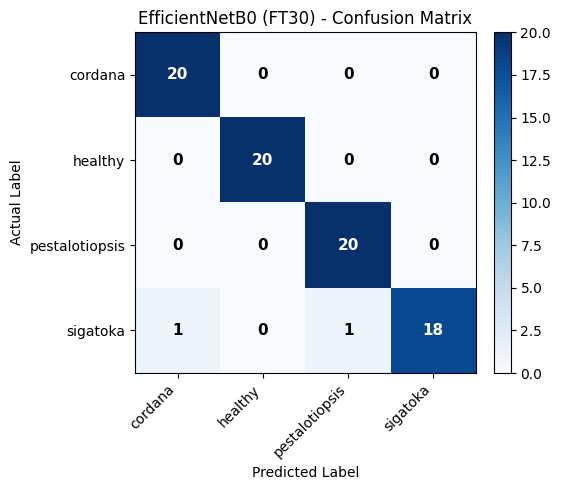

In [ ]:
# ============================================
# CELL FT30-3: Eval FT30 (Test set)
# ============================================

ft30_cm, ft30_rep = eval_model(ef_model)

ft30_params = ef_model.count_params()
ft30_size_mb = get_model_size_mb(ef_model)
ft30_inf_mean, ft30_inf_std = inference_ms_per_batch(ef_model, test_ds)

ft30_global = make_global_matrix(
    ft30_rep, ft30_params, ft30_size_mb,
    ft30_inf_mean, ft30_inf_std,
    ft30_train_time
)
ft30_cm_df = make_confusion_table(ft30_cm)

print("=== GLOBAL METRICS: EF_FT30 ===")
display(ft30_global)
display(ft30_cm_df)

plot_confusion_matrix_blue(ft30_cm, class_names, "EfficientNetB0 (FT30) - Confusion Matrix")


In [ ]:
# ============================================
# CELL FT30-4: Robust FT30
# ============================================

ft30_robust_df, ft30_robust_wide, ft30_avg_rob = run_robust_eval_one_variant("EF_FT30", ef_model)

print("\n=== ROBUST TABLE (EF_FT30) ===")
display(ft30_robust_df)
display(ft30_robust_wide)
print("AVG Robustness (EF_FT30):", ft30_avg_rob)



=== Evaluasi EF_FT30 pada Data Test Robust ===
Found 80 files belonging to 4 classes.
brightness_down  | low    | Acc = 0.9750
Found 80 files belonging to 4 classes.
brightness_down  | medium | Acc = 0.9750
Found 80 files belonging to 4 classes.
brightness_down  | high   | Acc = 0.9875
Found 80 files belonging to 4 classes.
brightness_up    | low    | Acc = 0.9875
Found 80 files belonging to 4 classes.
brightness_up    | medium | Acc = 0.9875
Found 80 files belonging to 4 classes.
brightness_up    | high   | Acc = 0.9875
Found 80 files belonging to 4 classes.
blur             | low    | Acc = 0.9750
Found 80 files belonging to 4 classes.
blur             | medium | Acc = 0.9250
Found 80 files belonging to 4 classes.
blur             | high   | Acc = 0.8375
Found 80 files belonging to 4 classes.
salt_pepper      | low    | Acc = 0.9250
Found 80 files belonging to 4 classes.
salt_pepper      | medium | Acc = 0.8750
Found 80 files belonging to 4 classes.
salt_pepper      | high   | Acc =

,Variant,Transform,Level,Accuracy
0,EF_FT30,brightness_down,low,0.97500
1,EF_FT30,brightness_down,medium,0.97500
2,EF_FT30,brightness_down,high,0.98750
3,EF_FT30,brightness_up,low,0.98750
4,EF_FT30,brightness_up,medium,0.98750
5,EF_FT30,brightness_up,high,0.98750
6,EF_FT30,blur,low,0.97500
7,EF_FT30,blur,medium,0.92500
8,EF_FT30,blur,high,0.83750
9,EF_FT30,salt_pepper,low,0.92500


Variant,Transform,Level,EF_FT30
0,blur,high,0.8375
1,blur,low,0.9750
2,blur,medium,0.9250
3,brightness_down,high,0.9875
4,brightness_down,low,0.9750
5,brightness_down,medium,0.9750
6,brightness_up,high,0.9875
7,brightness_up,low,0.9875
8,brightness_up,medium,0.9875
9,salt_pepper,high,0.7375


AVG Robustness (EF_FT30): 0.93125


In [ ]:
# ============================================
# CELL FT30-5: MACs & FLOPs FT30
# ============================================

ft30_macs, ft30_flops = get_macs_and_flops(ef_model)

print("=== EFISIENSI KOMPUTASI (EF_FT30) ===")
print(f"EfficientNetB0: MACs = {ft30_macs/1e6:.2f} MMACs | FLOPs = {ft30_flops/1e6:.2f} MFLOPs")


=== EFISIENSI KOMPUTASI (EF_FT30) ===
EfficientNetB0: MACs = 400.40 MMACs | FLOPs = 800.80 MFLOPs


In [ ]:
# ============================================
# CELL FT30-6: Save FT30 model
# ============================================

EF_FT30_PATH = os.path.join(MODEL_DIR, "efficientnetb0_ft30.keras")
ef_model.save(EF_FT30_PATH, include_optimizer=False)

print("Saved:", EF_FT30_PATH)


Saved: /content/drive/MyDrive/semester 7/Skripsi/models/efficientnetb0all/efficientnetb0_ft30.keras


In [ ]:
# ============================================
# CELL FT30-7: Final metric table (FT30)
# ============================================

ft30_epochs_ran = len(ft30_hist["loss"])
ft30_train_time_per_epoch = ft30_train_time / ft30_epochs_ran
ft30_test_ms_per_image = ft30_inf_mean / BATCH_SIZE
ft30_acc = float(ft30_rep["accuracy"])

final_ft30_df = pd.DataFrame({
    "Metric": [
        "Training time/epoch (s)",
        "Testing time/image (ms)",
        "Model size (MB)",
        "FLOPs (MFLOPs)",
        "MACs (MMACs)",
        "Accuracy",
        "Avg Robustness (acc)"
    ],
    "EF_FT30": [
        ft30_train_time_per_epoch,
        ft30_test_ms_per_image,
        ft30_size_mb,
        ft30_flops / 1e6,
        ft30_macs / 1e6,
        ft30_acc,
        ft30_avg_rob
    ]
})

final_ft30_df["EF_FT30"] = final_ft30_df["EF_FT30"].map(fmt)

print("=== HASIL AKHIR EF_FT30 ===")
display(final_ft30_df)


=== HASIL AKHIR EF_FT30 ===


,Metric,EF_FT30
0,Training time/epoch (s),6.9311
1,Testing time/image (ms),4.6935
2,Model size (MB),27.6412
3,FLOPs (MFLOPs),800.7954
4,MACs (MMACs),400.3977
5,Accuracy,0.9750
6,Avg Robustness (acc),0.9313


In [ ]:
# ============================================
# CELL SUMMARY-1: Gabungkan semua final metric jadi 1 tabel
# ============================================

final_all = final_fe_df.merge(final_ft10_df, on="Metric", how="left") \
                       .merge(final_ft20_df, on="Metric", how="left") \
                       .merge(final_ft30_df, on="Metric", how="left")

print("=== FINAL TABLE (EF_FE vs EF_FT10 vs EF_FT20 vs EF_FT30) ===")
display(final_all)


=== FINAL TABLE (EF_FE vs EF_FT10 vs EF_FT20 vs EF_FT30) ===


,Metric,EF_FE,EF_FT10,EF_FT20,EF_FT30
0,Training time/epoch (s),19.3122,9.3117,7.3248,6.9311
1,Testing time/image (ms),3.2525,3.2245,3.1808,4.6935
2,Model size (MB),16.3144,23.1087,26.5653,27.6412
3,FLOPs (MFLOPs),800.7954,800.7954,800.7954,800.7954
4,MACs (MMACs),400.3977,400.3977,400.3977,400.3977
5,Accuracy,0.9750,0.9750,0.9750,0.9750
6,Avg Robustness (acc),0.9135,0.9281,0.9344,0.9313


In [ ]:
# ============================================
# CELL SUMMARY-2: Tabel average semua varian (per metric)
# ============================================

avg_table = final_all.copy()

# kolom numeric = semua selain "Metric"
num_cols = [c for c in avg_table.columns if c != "Metric"]

# konversi kembali ke float (karena sudah diformat string 4 desimal)
for c in num_cols:
    avg_table[c] = avg_table[c].astype(float)

avg_vals = avg_table[num_cols].mean(axis=1)  # rata-rata per baris metric
avg_result = pd.DataFrame({
    "Metric": avg_table["Metric"],
    "AVG_ALL": avg_vals
})

avg_result["AVG_ALL"] = avg_result["AVG_ALL"].map(lambda x: f"{x:.4f}")

print("=== AVERAGE SEMUA VARIAN (AVG_ALL) ===")
display(avg_result)

final_with_avg = final_all.merge(avg_result, on="Metric", how="left")
display(final_with_avg)


=== AVERAGE SEMUA VARIAN (AVG_ALL) ===


,Metric,AVG_ALL
0,Training time/epoch (s),10.7200
1,Testing time/image (ms),3.5878
2,Model size (MB),23.4074
3,FLOPs (MFLOPs),800.7954
4,MACs (MMACs),400.3977
5,Accuracy,0.9750
6,Avg Robustness (acc),0.9268


,Metric,EF_FE,EF_FT10,EF_FT20,EF_FT30,AVG_ALL
0,Training time/epoch (s),19.3122,9.3117,7.3248,6.9311,10.7200
1,Testing time/image (ms),3.2525,3.2245,3.1808,4.6935,3.5878
2,Model size (MB),16.3144,23.1087,26.5653,27.6412,23.4074
3,FLOPs (MFLOPs),800.7954,800.7954,800.7954,800.7954,800.7954
4,MACs (MMACs),400.3977,400.3977,400.3977,400.3977,400.3977
5,Accuracy,0.9750,0.9750,0.9750,0.9750,0.9750
6,Avg Robustness (acc),0.9135,0.9281,0.9344,0.9313,0.9268


In [ ]:
# ============================================
# CELL COMB-FE-FT: Gabungan FE + FT dengan batas FT
# ============================================

def plot_fe_ft_combined(
    fe_hist,
    ft_hist,
    fe_epochs,
    title,
    ft_label="Fine-Tuning"
):
    # ---- Ambil key acc ----
    acc_key = "acc" if "acc" in fe_hist else "categorical_accuracy"
    val_acc_key = "val_acc" if "val_acc" in fe_hist else "val_categorical_accuracy"

    # ---- Gabung history ----
    train_acc = fe_hist[acc_key] + ft_hist[acc_key]
    val_acc   = fe_hist[val_acc_key] + ft_hist[val_acc_key]

    train_loss = fe_hist["loss"] + ft_hist["loss"]
    val_loss   = fe_hist["val_loss"] + ft_hist["val_loss"]

    epochs = range(1, len(train_acc) + 1)

    plt.figure(figsize=(14,5))

    # ===== Accuracy =====
    plt.subplot(1,2,1)
    plt.plot(epochs, train_acc, label="Train Acc")
    plt.plot(epochs, val_acc, label="Val Acc")

    plt.axvline(
        x=fe_epochs,
        color="red",
        linestyle="--",
        linewidth=2,
        label="Start Fine-Tuning"
    )

    plt.title(f"{title} - Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)

    # ===== Loss =====
    plt.subplot(1,2,2)
    plt.plot(epochs, train_loss, label="Train Loss")
    plt.plot(epochs, val_loss, label="Val Loss")

    plt.axvline(
        x=fe_epochs,
        color="red",
        linestyle="--",
        linewidth=2,
        label="Start Fine-Tuning"
    )

    plt.title(f"{title} - Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


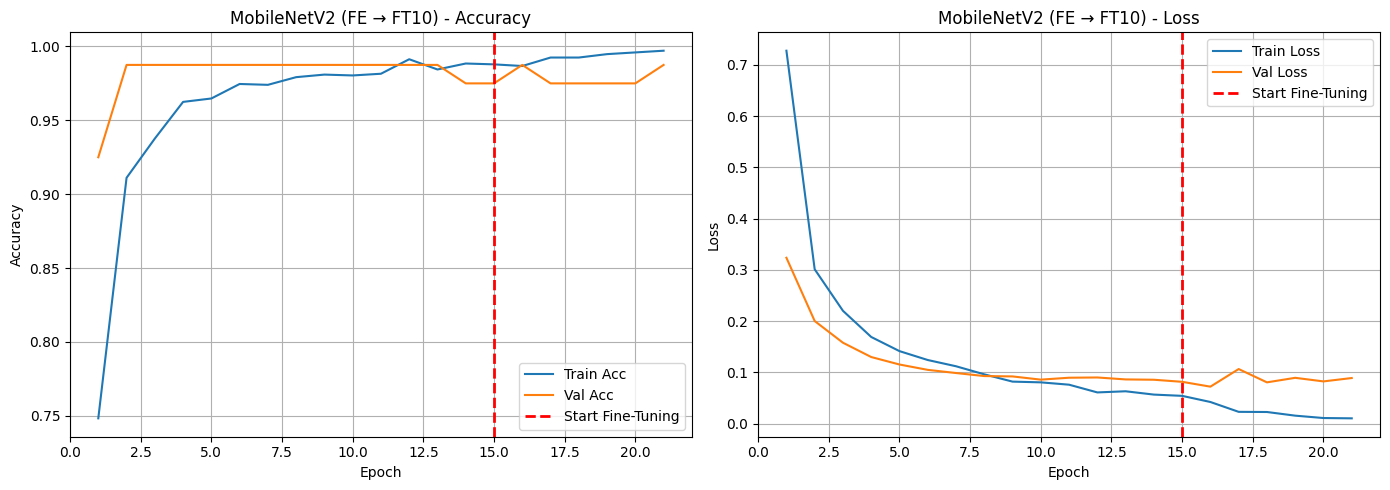

In [ ]:
plot_fe_ft_combined(
    fe_hist=fe_hist,
    ft_hist=ft10_hist,
    fe_epochs=len(fe_hist["loss"]),
    title="MobileNetV2 (FE → FT10)"
)


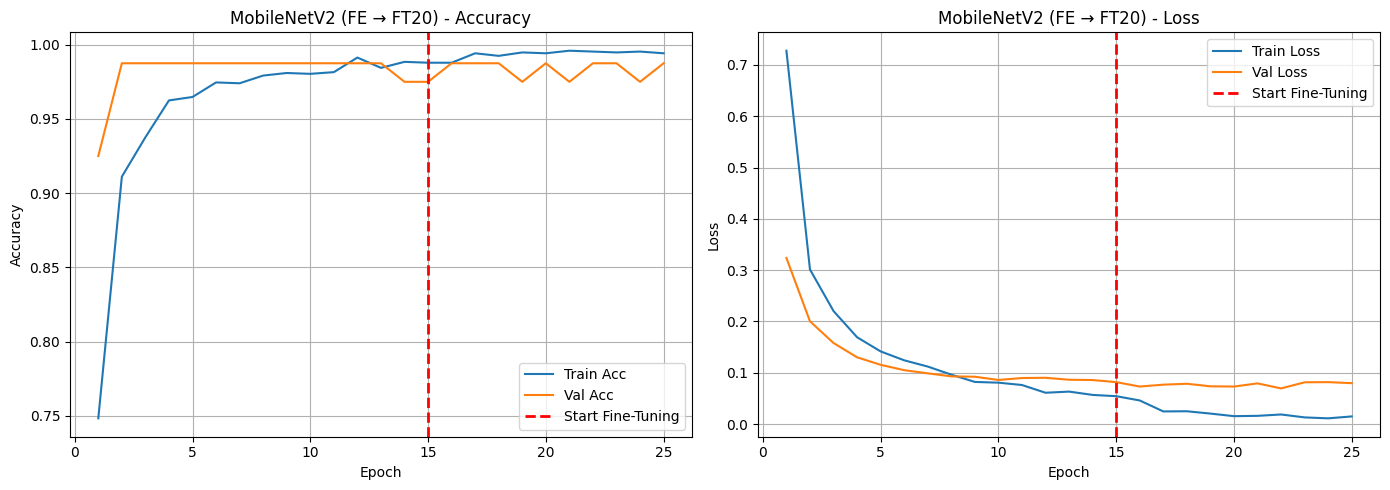

In [ ]:
plot_fe_ft_combined(
    fe_hist=fe_hist,
    ft_hist=ft20_hist,
    fe_epochs=len(fe_hist["loss"]),
    title="MobileNetV2 (FE → FT20)"
)


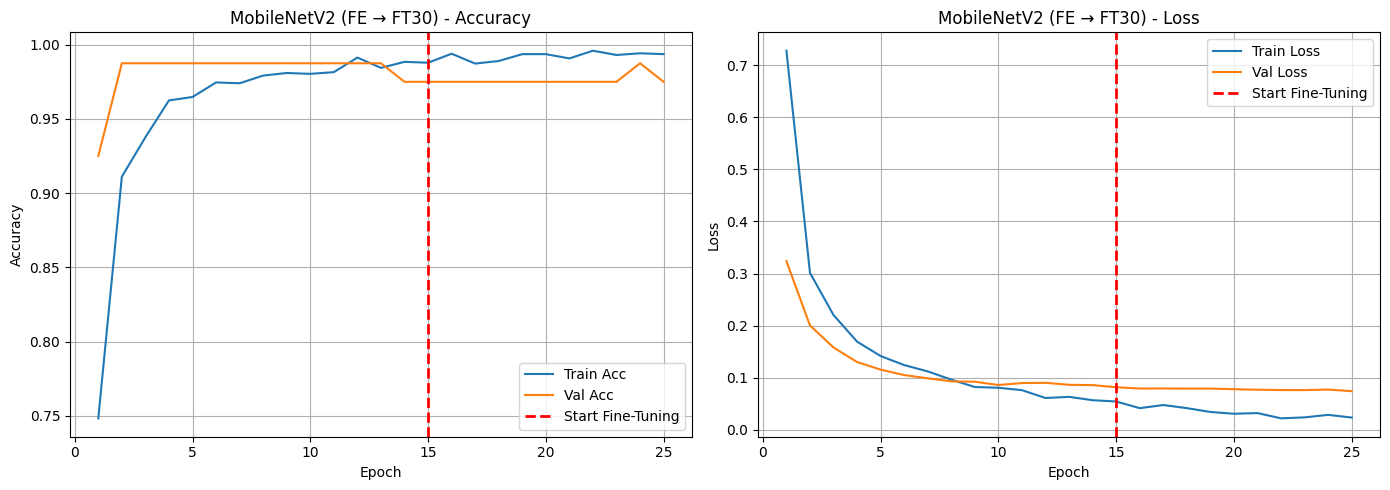

In [ ]:
plot_fe_ft_combined(
    fe_hist=fe_hist,
    ft_hist=ft30_hist,
    fe_epochs=len(fe_hist["loss"]),
    title="MobileNetV2 (FE → FT30)"
)
